# CSE252C: Homework 2
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Thu, May 21, at 4pm. 

## Q1: Using SphereFace [3] for Face Verification

1. In the first section, we will test a pretrained model of SphereFace on LFW [4] dataset. The LFW dataset is on `/datasets/cse152-252-sp20-public/hw2_data/lfw`. The dataset contains 6000 pairs of human face images with ground truth labels for whether they are from the same identity.
2. The PyTorch code of SphereFace is located in `./sphereFace`, which is modified based on the open source code from `https://github.com/clcarwin/sphereface_pytorch`. 
3. Run the following commands and report the accuracy of SphereFace on LFW verification. **(5 points)**
```
cd sphereFace
tar -zxf model.tar.gz
python lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

The metrics for SphereFace on LFW verification are:
1. LFWACC=0.9918
2. std=0.0051
3. thd=0.3095

4. Explain briefly how the following steps are performed when evaluating on LFW dataset: 
    1. Given the features extracted from the network, what is the metric used to measure the distance between two faces? (`lfw_eval.py`: Line 135) **(5 points)**
    2. How is the threshold set to determine whether two faces are from the same identity? How is the accuracy computed? (`lfw_eval.py`: Line 141 to 148) **(10 points)**

1. The metric used is the cosine distance between the features of two faces in the feature space;
2. It evaluates the thresholds using 10-fold cross validation. It divides the pairwise dataset into 10 folds, 9 of which are used for training and 1 used for testing. Then for each set of training and test data, it finds the best threshold that yields the highest accuracy on the training set. The accuracy is computed by taking the average of the accuracies obtained by different thresholds, under K-fold evaluation.

5. An important step before face recognition is face alignment, in which we warp and crop the image based on the location of facial landmarks.
    1. Briefly describe how we warp and crop the image. (`lfw_eval.py`: Line 11-26) **(5 points)**
    2. Instead of doing face alignment, crop an image patch of height 112 pixels and width 96 pixels at the center of the image. Report the accuracy.  **(10 points)**

A. First 5 reference points are pre-definied, and for each image we have 5 landmarks. Based on the mapping between the landmarks and the reference points, an affine transformation matrix is computed, and then the image is then transformed according to the transformation matrix. Finally, the image is cropped at the center based on the size of the patch.

B. 

## Q2: Using MTCNN [5] for Detecting Face Landmarks

1. Instead of using provided facial landmarks, we will now use MTCNN [5] for detecting them. The code is located at `./mtcnn`. Run the following commands to generate the facial landmarks. Include two example outputs in your report. **(5 points)**
```
cd MTCNN 
python lfw_landmark.py --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

2. Go to the `sphereFace` directory, run the following commands by setting flag `alignmentMode` to be 2. Report the error using the predicted facial landmarks. **(5 points)**
```
cd sphereFace
python lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/ --alignmentMode 2
```

The metrics for SphereFace on LFW verification are:
1. LFWACC=0.9845
2. std=0.0057
3. thd=0.2995

3. Next, answer the following questions:
    1. Is the result better than using the landmarks provided in the previous question? If not, how can you improve performance? **(5 points)**
    2.  What are the steps adopted by the method to achieve real-time speed? **(5 points)**
    3. Briefly describe how non-maximal suppression (NMS) is implemented in this method. (`src/box_utils.py`: Line 5-68) **(5 points)**

``Answer here.``

## Q3: Training SphereFace [3] on CASIA Dataset [6]

You will now train a network on the CASIA dataset [6] and test on the LFW dataset [4]. In this section, the skeleton code for training is given. CASIA-Webface dataset can be found at `/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace`.  
1. Go to directory of  `sphereFace` and open `faceNet.py`. Under class `CustomLinear` implement function $\psi$ as shown in Eq. (7) and Appendix G in [3], which is as follows. 
\begin{equation*}
\psi(\theta ) = (-1)^{k}\cos(m\theta )-2k, \quad \theta \in [\frac{k\pi}{m}, \frac{(k+1)\pi}{m}] \nonumber
\end{equation*}
Under class `CustomLoss`, implement the loss function. **(15 points)**

In [ ]:
import torch.nn as nn

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, m = 4 ):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features,out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m
        self.mlambda = [
            lambda x: x**0,
            lambda x: x**1,
            lambda x: 2*x**2-1,
            lambda x: 4*x**3-3*x,
            lambda x: 8*x**4-8*x**2+1,
            lambda x: 16*x**5-20*x**3+5*x
        ]

    def forward(self, input):
        x = input   # size=(B,F)    F is feature len
        w = self.weight # size=(F,Classnum) F=in_features Classnum=out_features

        ww = w.renorm(2,1,1e-5).mul(1e5)
        xlen = x.pow(2).sum(1).pow(0.5) # size=B
        wlen = ww.pow(2).sum(0).pow(0.5) # size=Classnum

        cos_theta = x.mm(ww) # size=(B,Classnum)
        cos_theta = cos_theta / torch.clamp(xlen.view(-1,1) * wlen.view(1,-1), min=1e-8)
        cos_theta = cos_theta.clamp(-1,1)

        # phi_theta implementation
        theta = torch.acos(cos_theta) # size=(B, Classnum)
        k = (theta * self.m / math.pi).floor() # size=(B,Classnum)
        phi_theta = (-1 * torch.ones(k.shape).cuda()).pow(k) * torch.cos(self.m * theta) - 2 * k # size=(B,Classnum) 
        
        cos_theta = cos_theta * xlen.view(-1,1)
        phi_theta = phi_theta * xlen.view(-1,1)

        output = (cos_theta,phi_theta)
        return output


class CustomLoss(nn.Module):
    def __init__(self ):
        super(CustomLoss, self).__init__()

        # Parameters for computing loss function
        self.it = 0
        self.LambdaMin = 5.0
        self.LambdaMax = 1500.0
        self.lamb = 1500.0

    def forward(self, input, target):
        self.it += 1
        cos_theta,phi_theta = input
        target = target.view(-1,1) #size=(B,1)
        
        # IMPLEMENT loss
        # target_out = torch.exp(phi_theta.gather(1, target)) # size=B 
        output = cos_theta * 1.0        # size=(B, classnum)
        index = cos_theta.data * 0.0 # set them all to 0
        index.scatter_(1, target.data.view(-1,1), 1) # setting ones at specific target value
        index = index.type(torch.bool)
        index = Variable(index)
        
        output[index] = (self.lamb * cos_theta[index] + phi_theta[index]) / (1 + self.lamb)
        self.lamb = max(self.LambdaMin, self.LambdaMax / (1 + self.it * 0.1))
        
        loss_all = - F.log_softmax(output)
        loss = loss_all.gather(1, target).mean()
        
        _, predictedLabel = torch.max(cos_theta.data, 1)
        predictedLabel = predictedLabel.view(-1, 1)
        accuracy = (predictedLabel.eq(target.data).cpu().sum().item() ) / float(target.size(0) )

        return loss, accuracy

2. Train the network using $\mathtt{casia\_train.py}$. You may try various hyperparameters like $m$, learning rate, batch size, training iterations and so on. Stop when you think the network behaves strangely (drop in accuracy, or loss stops decreasing). You may refer (and cite) any open source code (for example, \url{https://github.com/clcarwin/sphereface_pytorch}). Include the following in your report:
    1. Curves for training loss and accuracy on CASIA, which have been saved in the `checkpoint` directory (you may smooth the curves to make them look better). **(10 points)**
    2. Accuracy on the LFW dataset, evaluated using `lfw_eval.py`. You are expected to achieve accuracy higher than 90% on the LFW dataset. **(10 points)**

In [ ]:
"""
The following code is adapted from the following open-source code example:
https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
"""
import numpy as np

def smooth(x,window_len=11):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=np.ones(window_len,'d')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [ ]:
# Part A)
import numpy as np
import matplotlib.pyplot as plt
import os.path as path

window_length = 100

def plot_accuracy_loss(runs, labels=None):
    loss = []
    accuracy = []
    
    for run_folder in runs:
        loss.append(smooth(np.load(path.join(run_folder, "loss.npy")), window_length))
        accuracy.append(smooth(np.load(path.join(run_folder, "accuracy.npy")), window_length))

    
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.set_size_inches(10, 10)
    
    accuracy_lines = []
    loss_lines = []
    
    for (l, a, label) in zip(loss, accuracy, labels):
        loss_lines.append(ax1.plot(l, label=label))
        accuracy_lines.append(ax2.plot(a, label=label))
    
    ax1.set_title("Loss")
    ax1.legend()
    ax2.set_title("Accuracy")
    ax2.legend()
    plt.show()

run1 = "/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/sphereFace/checkpoint/run1"
plot_accuracy_loss([run1], ["Without BatchNorm"])

# print(accuracy.shape)

B. The performance metrics for LFW dataset are: 
* LFWACC=0.9772
* std=0.0070
* thd=0.3750

3. The architecture above is a 20-layer residual network as described in Table 2 of [3], but without batch normalization. Now add batch normalization after every convolutional and fully connected layer. Train the new network on CASIA dataset and test on LFW dataset. Following is a demonstration of a residual block with 128 filters and kernel size $3\times3$:
\begin{align}
y &=& \mathtt{CONV}_{3\times3, 128}(x) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
y &=& \mathtt{CONV}_{3\times3, 128}(y) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
\mathtt{OUT} &=& x + y
\end{align}
    1. Draw the training curves for accuracy and loss on CASIA and compare to the curve without batch normalization. **(10 points)**
    2. Report accuracy on the LFW dataset, evaluated using `lfw_eval.py`. **(10 points)**
    3. Do you achieve better performance on LFW? If yes, explain how batch normalization helps. If not, try to explain why the results are worse.  **(10 points)**

In [ ]:
run2 = "/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/sphereFace/checkpoint/run2"
plot_accuracy_loss([run1, run2], ["Without Batchnorm", "With Batchnorm"])

A. Using BatchNorm, the loss and accuracy curves show the same trend as without batchnorm. However, overall the loss is lower, and the accuracy is higher when using BatchNorm, in particular after ~7500 iterations.

B.The performance metrics for LFW are:
* LFWACC=0.9785
* std=0.0083 
* thd=0.3760



4. Randomly choose 10 identities from the CASIA dataset, forward pass all their images through the network and visualize the normalized features using tSNE \cite{maaten2008visualizing}. You can use code from \url{https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html} for visualization. Try a few random samples and include the figure that you consider most illustrative of the method. Retain the identities chosen here since they will be used again for the next question. **(10 points)**

In [ ]:
# Visualization for sphereFace
from PIL import Image
from sklearn.manifold import TSNE
from torch.autograd import Variable
from torch.utils.data import DataLoader

import os
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

os.chdir("/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/sphereFace")

import faceNet
import dataLoader

identities = []

dataset = "/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/hw2_data/CASIA-WebFace"
sphereFace_model = "/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/sphereFace/checkpoint/run2/netFinal_8.pth"
imWidth = 96
imHeight = 112
alignmentRoot = "/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/sphereFace/data/casia_landmark.txt"

def visualize_features(model, identities, random=False, num=10):
    tsne = TSNE(n_components=2)
    net = faceNet.faceNet(m = 4, feature = True)
    net.load_state_dict(torch.load(model))
    net.cuda()
    net.eval()
    net.feature = True
    
    identity_dict = {}
        
    faceLoader = dataLoader.IdentityLoader(
                      imageRoot = dataset,
                      alignmentRoot = alignmentRoot,
                      cropSize = (imWidth, imHeight)
                  )
    X = []
    y = []
    iteration = 1
    
    if random:
        for i, dataBatch in enumerate(faceLoader):
            if iteration > num:
                break
            # Read data
            imgs_cpu = dataBatch['img']
            identity = dataBatch['identity']
            for img in imgs_cpu:
                im = torch.tensor(img).float().cuda()
                output = net(im).cpu().detach().numpy()
                X.append(output)
                y.append(identity)
            iteration += 1
            
    else:
        for identity in identities:
            dataBatch = faceLoader.get(identity)
            imgs_cpu = dataBatch['img']
            for img in imgs_cpu:
                im = torch.tensor(img).float().cuda()
                output = net(im).cpu().detach().numpy()
                X.append(output)
                y.append(identity)

    X = np.array(X).squeeze()
    y = np.array(y).squeeze()
    
    features = tsne.fit_transform(X)
    
    # print("The shape of feature is: %s" % (features.shape,))
    
    fig = plt.figure()
    cmap = matplotlib.cm.get_cmap('Spectral')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=num-1)
    
    id_list = np.unique(y)
    color = [cmap(norm(np.where(id_list == i)[0][0])) for i in y]
    
    print(id_list)
    
    plt.scatter(X[:, 0], X[:, 1], c=color)
    plt.show()

In [ ]:
identities = ['0000107','0003072','0005036','0206717','0801051','0804670','1059359',
 '1265635','2375297','4883718']
visualize_features(sphereFace_model, identities, random=False, num=10)

## Q4: Training CosFace [7] on CASIA Dataset [6]

In this section, you are required to implement CosFace based on the code you use in the previous section, train it on CASIA dataset and test on LFW dataset. 
1. Go to directory `./cosFace` and open `faceNet.py`. Again implement the function $\psi$ and the loss function of CosFace under `CustomLinear` and `CustomLoss` in `faceNet.py`. You may check (and duly cite) any open source implementation for hints on improving the performance. **(15 points)**

In [ ]:
import torch.nn as nn

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, m = 0.35):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features,out_features) )
        self.weight.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m

    def forward(self, input):
        x = input   # size=(B,F)    F is feature len
        w = self.weight # size=(F,Classnum) F=in_features Classnum=out_features

        ww = w.renorm(2,1,1e-5).mul(1e5)
        xlen = x.pow(2).sum(1).pow(0.5) # size=B
        wlen = ww.pow(2).sum(0).pow(0.5) # size=Classnum

        cos_theta = x.mm(ww) # size=(B,Classnum)
        cos_theta = cos_theta / torch.clamp(xlen.view(-1,1) * wlen.view(1,-1), min=1e-8 )
        cos_theta = cos_theta.clamp(-1,1)

        phi_theta = cos_theta - self.m

        output = (cos_theta,phi_theta)
        return output


class CustomLoss(nn.Module):
    def __init__(self, s=64 ):
        super(CustomLoss, self).__init__()
        self.s = s

    def forward(self, input, target):
        cos_theta,phi_theta = input
        target = target.view(-1,1) #size=(B,1)

        output = cos_theta * self.s  # size=(B, classnum)
        index = cos_theta.data * 0.0 # set them all to 0
        index.scatter_(1, target.data.view(-1,1), 1) # setting ones at specific target value
        index = index.type(torch.bool)
        # print(index)
        index = Variable(index)
        
        output[index] = self.s * phi_theta[index]
        loss_all = - F.log_softmax(output)
        loss = loss_all.gather(1, target).mean()

        _, predictedLabel = torch.max(cos_theta.data, 1)
        predictedLabel = predictedLabel.view(-1, 1)
        accuracy = (predictedLabel.eq(target.data).cpu().sum().item() ) / float(target.size(0) )

        return loss, accuracy


class faceNet(nn.Module):
    def __init__(self,classnum=10574, feature=False, m = 1.35):
        super(faceNet, self).__init__()
        self.classnum = classnum
        self.feature = feature

        self.conv1_1 = nn.Conv2d(3,64,3,2,1) #=>B*64*56*48
        self.bn1_1   = nn.BatchNorm2d(64)
        self.relu1_1 = nn.PReLU(64) 
        self.conv1_2 = nn.Conv2d(64,64,3,1,1)
        self.bn1_2   = nn.BatchNorm2d(64)
        self.relu1_2 = nn.PReLU(64)
        self.conv1_3 = nn.Conv2d(64,64,3,1,1)
        self.bn1_3   = nn.BatchNorm2d(64)
        self.relu1_3 = nn.PReLU(64)

        self.conv2_1 = nn.Conv2d(64,128,3,2,1) #=>B*128*28*24
        self.bn2_1   = nn.BatchNorm2d(128)
        self.relu2_1 = nn.PReLU(128)
        self.conv2_2 = nn.Conv2d(128,128,3,1,1)
        self.bn2_2   = nn.BatchNorm2d(128)
        self.relu2_2 = nn.PReLU(128)
        self.conv2_3 = nn.Conv2d(128,128,3,1,1)
        self.bn2_3   = nn.BatchNorm2d(128)
        self.relu2_3 = nn.PReLU(128)

        self.conv2_4 = nn.Conv2d(128,128,3,1,1) #=>B*128*28*24
        self.bn2_4   = nn.BatchNorm2d(128)
        self.relu2_4 = nn.PReLU(128)
        self.conv2_5 = nn.Conv2d(128,128,3,1,1)
        self.bn2_5   = nn.BatchNorm2d(128)
        self.relu2_5 = nn.PReLU(128)

        self.conv3_1 = nn.Conv2d(128,256,3,2,1) #=>B*256*14*12
        self.bn3_1   = nn.BatchNorm2d(256)
        self.relu3_1 = nn.PReLU(256)
        self.conv3_2 = nn.Conv2d(256,256,3,1,1)
        self.bn3_2   = nn.BatchNorm2d(256)
        self.relu3_2 = nn.PReLU(256)
        self.conv3_3 = nn.Conv2d(256,256,3,1,1)
        self.bn3_3   = nn.BatchNorm2d(256)
        self.relu3_3 = nn.PReLU(256)

        self.conv3_4 = nn.Conv2d(256,256,3,1,1) #=>B*256*14*12
        self.bn3_4   = nn.BatchNorm2d(256)
        self.relu3_4 = nn.PReLU(256)
        self.conv3_5 = nn.Conv2d(256,256,3,1,1)
        self.bn3_5   = nn.BatchNorm2d(256)
        self.relu3_5 = nn.PReLU(256)

        self.conv3_6 = nn.Conv2d(256,256,3,1,1) #=>B*256*14*12
        self.bn3_6   = nn.BatchNorm2d(256)
        self.relu3_6 = nn.PReLU(256)
        self.conv3_7 = nn.Conv2d(256,256,3,1,1)
        self.bn3_7   = nn.BatchNorm2d(256)
        self.relu3_7 = nn.PReLU(256)

        self.conv3_8 = nn.Conv2d(256,256,3,1,1) #=>B*256*14*12
        self.bn3_8   = nn.BatchNorm2d(256)
        self.relu3_8 = nn.PReLU(256)
        self.conv3_9 = nn.Conv2d(256,256,3,1,1)
        self.bn3_9   = nn.BatchNorm2d(256)
        self.relu3_9 = nn.PReLU(256)

        self.conv4_1 = nn.Conv2d(256,512,3,2,1) #=>B*512*7*6
        self.bn4_1   = nn.BatchNorm2d(512)
        self.relu4_1 = nn.PReLU(512)
        self.conv4_2 = nn.Conv2d(512,512,3,1,1)
        self.bn4_2   = nn.BatchNorm2d(512)
        self.relu4_2 = nn.PReLU(512)
        self.conv4_3 = nn.Conv2d(512,512,3,1,1)
        self.bn4_3   = nn.BatchNorm2d(512)
        self.relu4_3 = nn.PReLU(512)

        self.fc5 = nn.Linear(512*7*6,512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc6 = CustomLinear(in_features = 512,
                out_features = self.classnum, m=m)


    def forward(self, x):

        x = self.relu1_1(self.bn1_1(self.conv1_1(x)))
        x = x + self.relu1_3(self.bn1_3(self.conv1_3(self.relu1_2(self.bn1_2(self.conv1_2(x))))))

        x = self.relu2_1(self.bn2_1(self.conv2_1(x)))
        x = x + self.relu2_3(self.bn2_3(self.conv2_3(self.relu2_2(self.bn2_2(self.conv2_2(x))))))
        x = x + self.relu2_5(self.bn2_5(self.conv2_5(self.relu2_4(self.bn2_4(self.conv2_4(x))))))

        x = self.relu3_1(self.bn3_1(self.conv3_1(x)))
        x = x + self.relu3_3(self.bn3_3(self.conv3_3(self.relu3_2(self.bn3_2(self.conv3_2(x))))))
        x = x + self.relu3_5(self.bn3_5(self.conv3_5(self.relu3_4(self.bn3_4(self.conv3_4(x))))))
        x = x + self.relu3_7(self.bn3_7(self.conv3_7(self.relu3_6(self.bn3_6(self.conv3_6(x))))))
        x = x + self.relu3_9(self.bn3_9(self.conv3_9(self.relu3_8(self.bn3_8(self.conv3_8(x))))))

        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))
        x = x + self.relu4_3(self.bn4_3(self.conv4_3(self.relu4_2(self.bn4_2(self.conv4_2(x))))))

        x = x.view(x.size(0),-1)
        x = self.bn5(self.fc5(x))

        if self.feature:
            return x

        x = self.fc6(x)
        return x


2. Copy the 20-layer residual network with batch normalization you have written in the previous section to `faceNet.py`. Use that network structure for training and testing. Train the network on CASIA dataset. Again you are free to change any hyper parameters but report the hyper parameters that you think might influence the performance. Again draw the curve of loss and accuracy of training. Report the accuracy on LFW dataset. **(20 points)**

In [ ]:
cosFace_run = "/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/cosFace/checkpoint"
plot_accuracy_loss([cosFace_run], ["cosFace"])

The performance on LFW dataset:

* LFWACC=0.9875
* std=0.0058
* thd=0.2165

3. If you achieve better performance compared to SphereFace, well done! Can you provide a reason? If you do not outperform SphereFace, can you provide a cause? **(10 points)**

Based on the accuracy (98.75% vs. 97.72%) performs better than SphereFace. 

The reason is that...

4. Plot the tSNE visualization of the CosFace embedding for the same identities from the CASIA dataset used to visualize the SphereFace embedding in the previous question. **(10 points)**

In [1]:
cosFace_model = "/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/cosFace/checkpoint/netFinal_9.pth"
visualize_features(cosFace_model, identities, random=False, num=10)

NameError: name 'visualize_features' is not defined

## Q5 Human Pose Estimation with Convolutional Pose Machines (CPM)

In this question, you will be given code adapted from [PyTorch implementation of one of the CPM model [1]](https://github.com/Hzzone/pytorch-openpose), which is an follow-up work of the original Convolution Pose Machine [2], and shares the Part Confidence Maps estimation module with [2]. In this question you will be given a trained CPM model and gain insights about the model design and outputs.

- ``cd pytorch-openpose``
- Set up the environment following the instructions at ``pytorch-openpose/README.md`` (Getting Started - Install Requriements)
- Download the ``body_pose_model.pth`` from [Dropbox](https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=0) and place under ``pytorch-openpose/model``

(1) Run the inference code on the given image.

(425, 640, 3)
torch.Size([1, 19, 92, 139])


<Figure size 432x288 with 0 Axes>

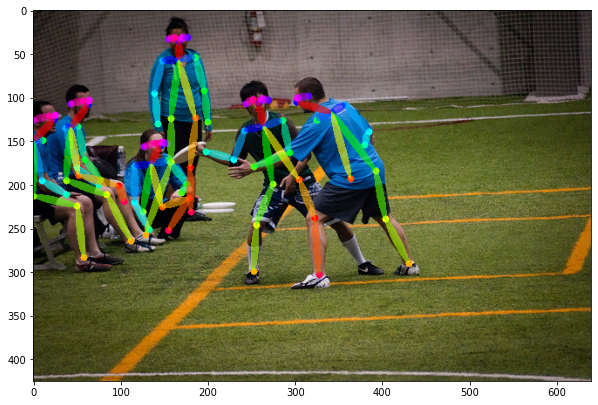

(360, 640, 3)
torch.Size([1, 19, 92, 164])


<Figure size 432x288 with 0 Axes>

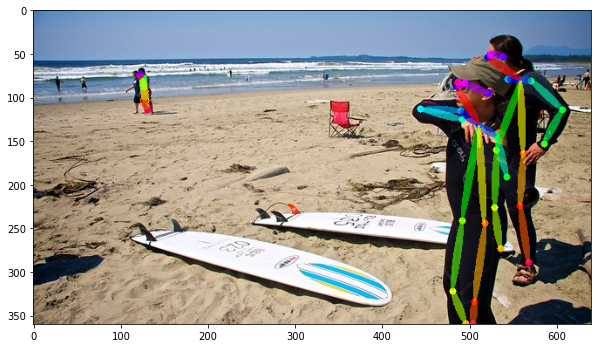

/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/pytorch-openpose/src/body.py:145: RuntimeWarning: invalid value encountered in true_divide
  vec = np.divide(vec, norm)
/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/pytorch-openpose/src/body.py:158: RuntimeWarning: invalid value encountered in greater
  criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)


(480, 640, 3)
torch.Size([1, 19, 92, 123])


<Figure size 432x288 with 0 Axes>

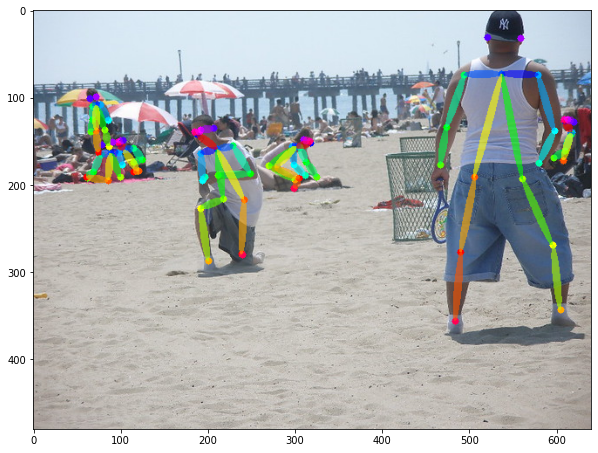

(533, 800, 3)
torch.Size([1, 19, 92, 139])


<Figure size 432x288 with 0 Axes>

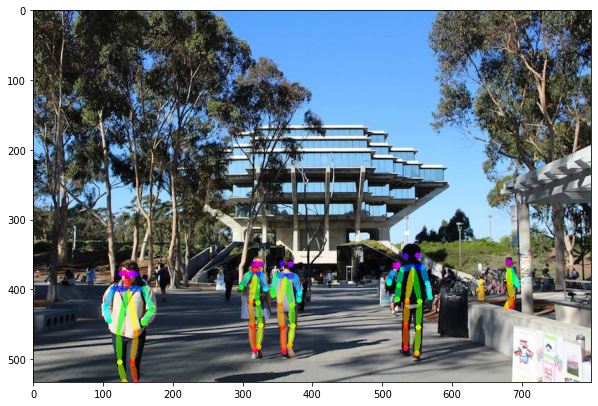

(1080, 1920, 3)
torch.Size([1, 19, 92, 164])


<Figure size 432x288 with 0 Axes>

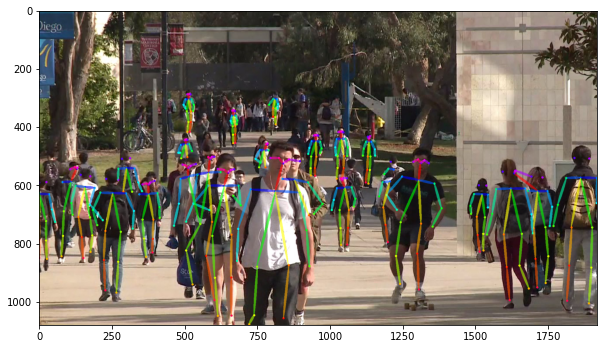

In [1]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np
import os

os.chdir("/home/jamesdi1993/workspace/UCSD/cse252c-sp20/HW2/cse252c_hw2_release/pytorch-openpose")

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')

# test_image = 'images/demo.jpg'

# part 3
img_list = ['demo_coco.jpg', 'demo_coco2.jpg', 'demo_beach.jpg', 'demo_ucsd.jpg', 'demo_ucsd2.jpg']

for img in img_list:
    test_image = os.path.join('images', img)
    
    fig = plt.figure()
    oriImg = cv2.imread(test_image)  # B,G,R order

    candidate, subset, heatmap_list, heatmap_list_converted_list = body_estimation(oriImg)
    heatmap_0 = heatmap_list[0] 

    print(oriImg.shape,)
    print(heatmap_0.shape,)
    canvas = copy.deepcopy(oriImg)
    canvas = util.draw_bodypose(canvas, candidate, subset)

    plt.figure(figsize=(10, 10))
    plt.imshow(canvas[:, :, 
                      [2, 1, 0]])
    # plt.axis('off')
    plt.show()

(a) Visualize the output keypoint detection result. **(5 points)**

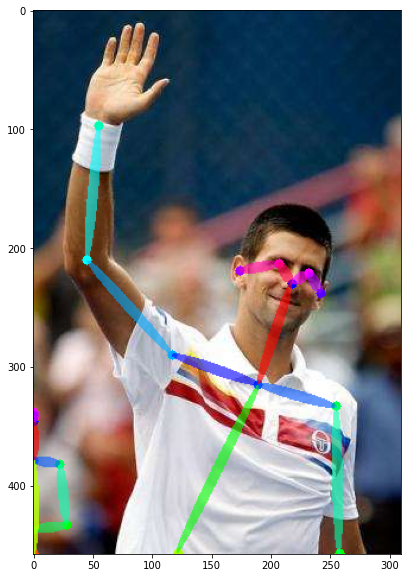

(b) What is the ratio of size $\lambda=H/H'$ between the input image **im** (Line 57 of ``body.py``) 
of shape [1, 3, H, W] and the output heatmap **heatmap_0** of shape [1, D, H', W']? **(5 points)**

The ratio $\lambda = 458 / 92 \approx 5$.

(c) What module in the model is reponsible for this scaling? **(5 points)**

``Answer the question here``

(2) ``heatmap_list_converted_list[0]`` is a list of heatmaps from all 6 layers: [out1_2, out2_2, out3_2, out4_2, out5_2, out6_2], where the output of each layer is of shape [H, W, D].

This snippet gives the function to visualize the $d_{th}$ feature map from the layer **layer_idx**

In [ ]:
layer_idx = -1

for d in range(heatmap_list_converted_list[0][layer_idx].shape[2]):
    layer_idx = 0
    heatmap = heatmap_list_converted_list[0][layer_idx][:, :, d]
    util.overlay_heatmap(canvas, heatmap)

(a) What is D? And given D can you tell what is the number of keypoints that the model is trying to estimate? **(5 points)**

D is number of keypoints (joints, necks, elbows) etc that we're trying to estimate. 

(b) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=2**. **(5 points)**

In [ ]:
layer_idx = [0, 5]
d = 2

for index in layer_idx:
    print("Heatmap from layer: %s" % index)
    heatmap = heatmap_list_converted_list[0][index][:, :, d]
    util.overlay_heatmap(canvas, heatmap)

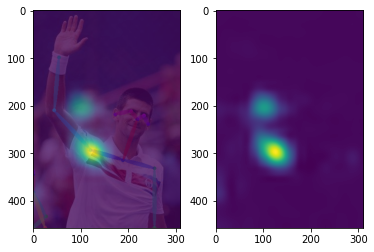
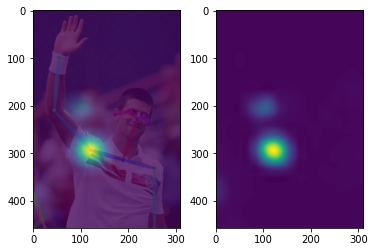

The heatpmap from layer 5 is more concentrated than the heatmap predicted from layer 0. The upper (wrong) region has lower probability in layer 5, and the areas for both regions are smaller in layer 5. This indicates that in later layer the prediction is more confident. 

(c) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=3**. **(5 points)**

In [ ]:
d = 3

for index in layer_idx:
    print("Heatmap from layer: %s" % index)
    heatmap = heatmap_list_converted_list[0][index][:, :, d]
    util.overlay_heatmap(canvas, heatmap)

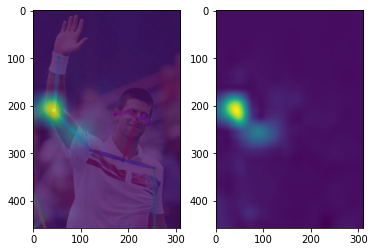
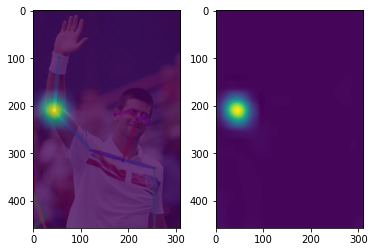

In the later layer(5), the confidence is more concentrated around 1 area which corresponds to the correct elbow joint position. In the initial stage (layer 1), the predictions have two high-confidence areas. 

(d) State and justify the shared difference in these comparisons? You may get some hint from the model design. **(5 points)**

For both key points, the high confidence regions in layer 5 correspond roughly the same to the high-confidence regions in layer 0. The prediction in layer 0 have two high confidence regions, whereas the prediction in layer 5 have only 1 high confidence region. Moreover, in both cases the high confidence regions are large in layer 1, but become smaller in layer 5. 

The reason for this difference is because of the cascade network design. Since the later network predicts the difference between the true heatmap and the initial heatmap, later layers' output should correspond roughly to the initial output. In addition, later layer have more context information about the global and spatial structure, and hence should be more confident in its prediction.

(3) Set **multi_scale=False** in Line 38 of ``body.py`` and re-run the code from question 5(1). 

(a) Visualize the output below. **(5 points)**

Multiscale=True | Multiscale=False
- | - 
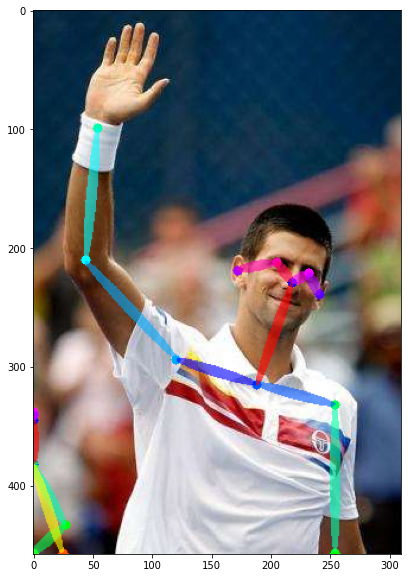 | 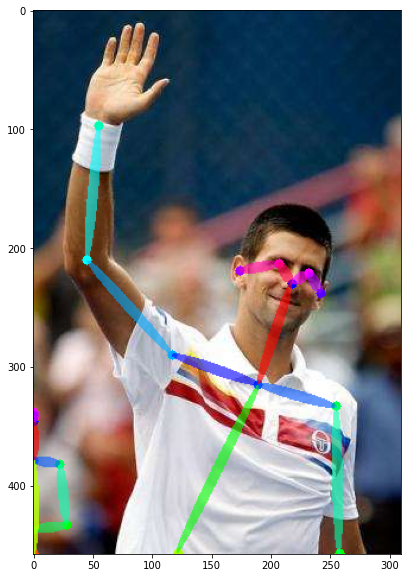

(b) Do the same comparison with additional images of ``demo_coco.jpg``, ``demo_coco2.jpg``, ``demo_beach.jpg``, ``demo_ucsd.jpg``, ``demo_ucsd2.jpg``.  **(5 points)**

**NOTE: you might need to restart the kernel each time you change the multi_scale flag. This may be required to re-initialize the model. [Kernel]-->[Restart]**

Multiscale=True | Multiscale=False
- | - 
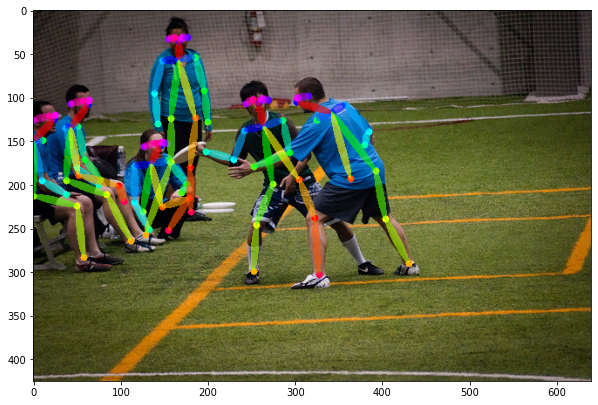   | 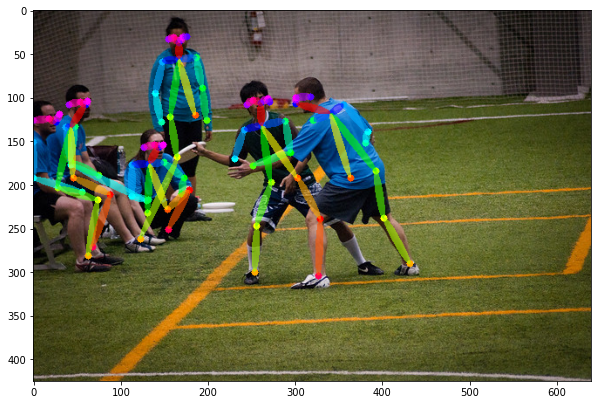
- | -
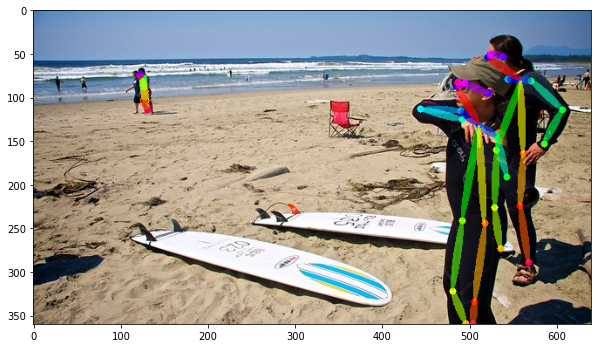 | 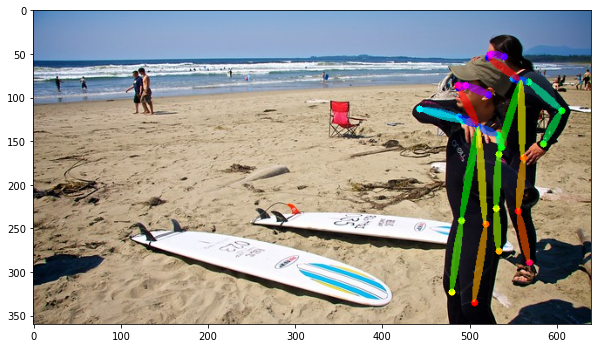
- | -
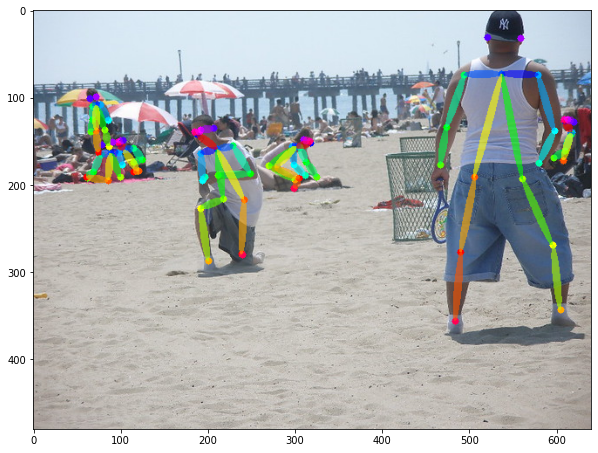 | 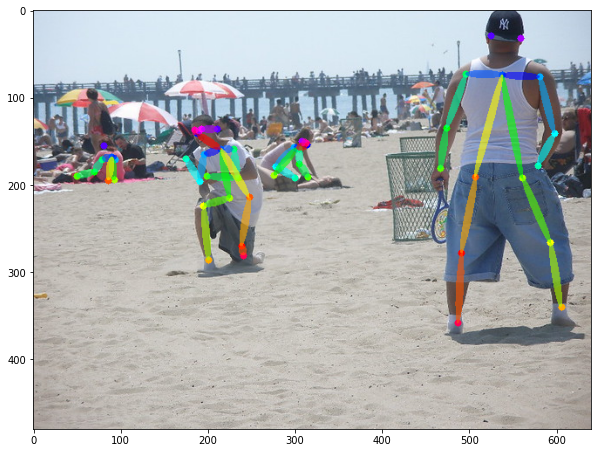
- | -
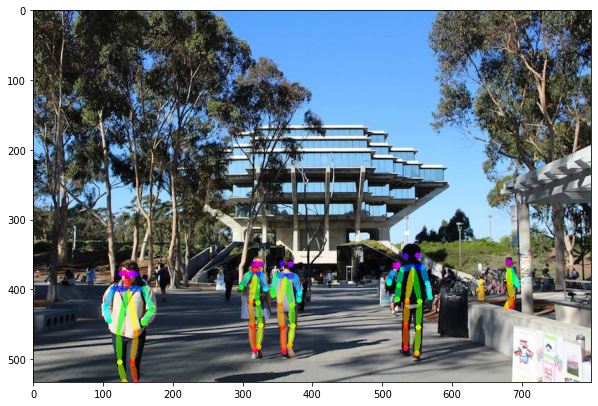   | 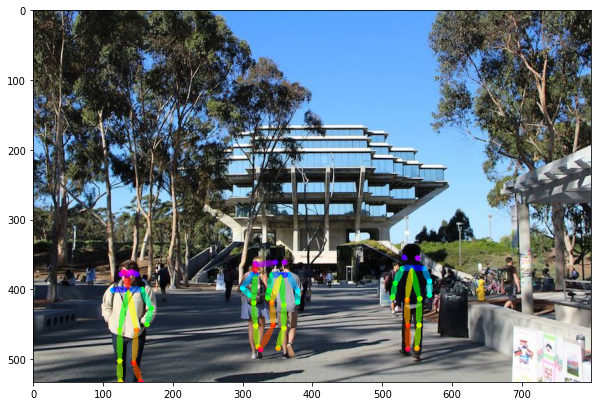
- | -
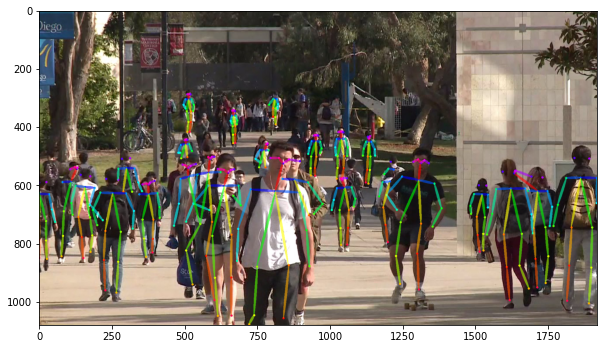 | 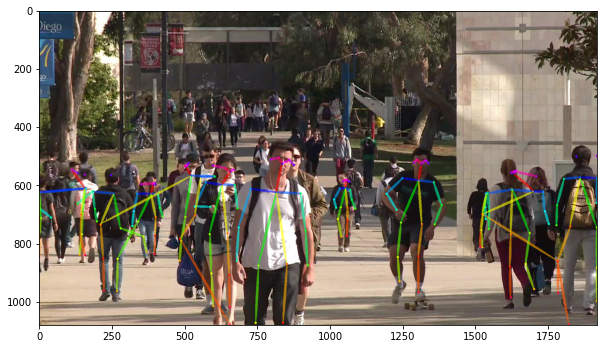

(c) What shared difference can you spot in most of the comparisons? Justify the difference. **(5 points)**

There are two shared difference in most of the difference:

1) When multicale is turned on, it includes some prediction of the occluded joints, which are missing in the prediction when multiscale is turned off;

2) When the people appear small in the image, the prediction with multi-scaling can still predict their joints (for example in the last image in the further background).  


# Reference
[1] Cao, Zhe. et al. "Realtime multi-person 2d pose estimation using part affinity fields." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2017.

[2] Wei, Shih-En. et al. "Convolutional pose machines." Proceedings of the IEEE conference on Computer Vision and Pattern Recognition. 2016.

[3] Liu, Weiyang. et al. "SphereFace: Deep Hypersphere Embedding for Face Recognition." arXiv:1704.08063.

[4] Huang, Gary. et al. "Labeled faces in the wild:  Adatabase for studying face recognition in unconstrained environments." Technical Report 07-49, Universityof Massachusetts, Amherst, October 2007.

[5] Zhang, Kaipeng. et al. "Joint face detection and alignment usingmultitask cascaded convolutional networks." IEEE Signal Processing Letters, 23(10):1499–1503, 2016.

[6] Yi, Dong. et al.  Learning face representation from scratch. arXiv:1411.7923.

[7] Wang, Hao. et al.Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE Conference onComputer Vision and Pattern Recognition, pages 5265–5274, 2018.